Energy Disaggregation using Neural Networks
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


In [2]:
from keras.layers.normalization import BatchNormalization

The following functions are used to extract the time and day information from a timestamp value.

The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [3]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [5]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [6]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

Data Preprocessing for ECO - Summer
------------------------------

The following function takes as input the file path, the channel index and the quantity name as input and loads the appropriate data files. It then joins themains and the output quantity based on the timestamp values, extracts time features from the timestamp and splits the input and output into two arrays.

In [4]:
from os import walk
path = "C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/05_sm_csv/05"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [5]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

215

In [6]:
df2 = pd.read_csv("C:/Users/ghoshp/Downloads/IE594964/IE594964/REP594965/05_occupancy_csv/05_winter.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

31

In [7]:
import datetime
summer = df2.index.tolist()
# for i in range(len(summer)):
#     item = pd.to_datetime(summer[i])
#     item = item.strftime('%Y%m%d')
#     summer[i] = item
df_summer = {}
for key in df.keys():
    if key in summer:
        df_summer[key]=df[key]
len(df_summer)
#df_summer["20120730"]

31

In [11]:
n = 900  #chunk row size
summer_features = pd.DataFrame()
for day, data in df_summer.items():
    list_df_summer = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_summer:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
#     data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
#                                             std1,std2,std3,std123,range1,range2,range3,range123,ptime)), 
#                             columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
#                                        'mean123','std1','std2','std3','std123',
#                                        'range1','range2','range3','range123','ptime'])
    
    summer_features = summer_features.append(data)
summer_features.loc[summer_features.ptime < 25, 'ptime'] = 0
summer_features.loc[summer_features.ptime > 89, 'ptime'] = 0
summer_features = summer_features.loc[(summer_features['ptime'] >0)]
summer_features['ptime'] = summer_features['ptime'] - 24

#         print(summer_features)
#        break

In [12]:
summer_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,122.401,35.801,70.629,229.064,204.259,82.470,107.598,392.284,195.692021,72.403376,...,0.994153,0.0,0.0,0.0,0.0,81.858,46.669,36.969,163.220,1.0
25,197.559,80.845,104.329,385.924,1157.250,142.042,1387.810,1669.410,216.174513,101.310012,...,0.902554,0.0,0.0,0.0,0.0,959.691,61.197,1283.481,1283.486,2.0
26,196.519,80.683,218.922,501.446,1146.240,166.246,1839.940,2203.960,215.167907,124.570061,...,0.927838,0.0,0.0,0.0,0.0,949.721,85.563,1621.018,1702.514,3.0
27,196.977,80.240,214.808,493.283,317.038,239.894,1648.950,1986.780,215.540882,100.326511,...,0.481977,0.0,0.0,0.0,0.0,120.061,159.654,1434.142,1493.497,4.0
28,307.782,104.745,213.713,627.768,1941.230,166.327,219.606,2262.880,835.996706,111.097814,...,0.990234,0.0,0.0,0.0,0.0,1633.448,61.582,5.893,1635.112,5.0
29,891.074,78.311,214.189,1186.970,1844.780,295.267,1364.830,2356.760,913.989188,108.523764,...,0.896561,0.0,0.0,0.0,0.0,953.706,216.956,1150.641,1169.790,6.0
30,889.328,80.854,215.160,1247.270,900.870,295.334,1575.540,2592.330,895.139142,147.624132,...,0.493415,0.0,0.0,0.0,0.0,11.542,214.480,1360.380,1345.060,7.0
31,889.310,24.341,104.943,1020.410,1833.950,81.540,421.713,2260.860,912.137182,32.271043,...,0.972293,0.0,0.0,0.0,0.0,944.640,57.199,316.770,1240.450,8.0
32,131.496,24.159,71.799,375.068,896.311,25.432,1243.090,1471.390,479.982059,24.842324,...,0.976790,0.0,0.0,0.0,0.0,764.815,1.273,1171.291,1096.322,9.0
33,130.804,24.588,148.111,307.140,1089.160,25.670,291.357,1348.760,150.469628,25.137758,...,0.957942,0.0,0.0,0.0,0.0,958.356,1.082,143.246,1041.620,10.0


In [13]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_summer = []
    list_oc_summer = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_summer:
        occ_summer.append(np.bincount(chunk).argmax())
    occ_summer = occ_summer[24:89]
#     print(len(occ_summer))
    cuml_list.extend(occ_summer)
#     print(len(cuml_list))
occ_summer_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
# print(occ_summer_data)    
#     print(len(list_oc_summer))
#     if row[0] > '06:00:00':
#         print(row[1])
    

In [14]:
occ_summer_data

,occupancy
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [15]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

In [16]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

Standardizing data
================

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(summer_features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
summer_std = scaler.transform(summer_features)

In [19]:
summer_std[np.isnan(summer_std)] = 0

PCA
====

In [20]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [21]:
pca.fit(summer_std)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
pca.n_components_

16

In [23]:
summer_pca = pca.transform(summer_std)

In [24]:
summer_pca.shape

(2015, 16)

Training and Testing
-------------------------------

The model is trained on the"dishwasher" appliance for house 1. The training set comprises 20000 samples and the testing set comprises 2000 samples. The loss curve is plotted. he predicted values are also plotted against the actual values forthe test set.

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_pca, occ_summer_data, test_size=0.15,shuffle=True)

In [77]:
X_train.shape

(1712, 16)

Model Specification
-------------------------------
The following function is used to create the model.

In [27]:
def init_model():
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(16,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True,
#                                   stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.25))
#     model.add(Bidirectional(LSTM(128, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
#     model.add(Bidirectional(LSTM(64, return_sequences=True, stateful=False,kernel_initializer="he_uniform"), merge_mode='concat'))
#     model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [28]:
def create_seq(X):
    res = []
    rem = X.shape[0] % 4
    for i in range(0,X.shape[0],4):
#         print(i)
        if  (i+4) > X.shape[0]:
            balc = X.shape[0] - i
            res.append(np.concatenate((X[i:i+balc,:],np.zeros((i+4 - X.shape[0],X.shape[1])))))
        else:
            res.append(X[i:i+4,:])
    res = np.array(res)
#     print(len(res))
    return res
   

W0829 11:36:01.838653  9036 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 11:36:02.207432  9036 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 11:36:02.225419  9036 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 11:36:02.350339  9036 deprecation_wrapper.py:119] From C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Pleas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 64)            32832     
__________

1712/1712 [==============================] - 1s 650us/step - loss: 0.3250 - acc: 0.8511 - val_loss: 0.3359 - val_acc: 0.8680
Epoch 39/200
1712/1712 [==============================] - 1s 646us/step - loss: 0.3142 - acc: 0.8452 - val_loss: 0.3377 - val_acc: 0.8647
Epoch 40/200
1712/1712 [==============================] - 1s 660us/step - loss: 0.3213 - acc: 0.8475 - val_loss: 0.3372 - val_acc: 0.8614
Epoch 41/200
1712/1712 [==============================] - 1s 683us/step - loss: 0.3130 - acc: 0.8382 - val_loss: 0.3498 - val_acc: 0.8515
Epoch 42/200
1712/1712 [==============================] - 1s 693us/step - loss: 0.3240 - acc: 0.8534 - val_loss: 0.3445 - val_acc: 0.8845
Epoch 43/200
1712/1712 [==============================] - 1s 662us/step - loss: 0.3068 - acc: 0.8586 - val_loss: 0.3617 - val_acc: 0.8548
Epoch 44/200
1712/1712 [==============================] - 1s 674us/step - loss: 0.3089 - acc: 0.8522 - val_loss: 0.3489 - val_acc: 0.8581
Epoch 45/200
1712/1712 [=======================

1712/1712 [==============================] - 1s 692us/step - loss: 0.2013 - acc: 0.9095 - val_loss: 0.3888 - val_acc: 0.8746
Epoch 98/200
1712/1712 [==============================] - 1s 701us/step - loss: 0.2115 - acc: 0.9019 - val_loss: 0.3811 - val_acc: 0.8746
Epoch 99/200
1712/1712 [==============================] - 1s 682us/step - loss: 0.2261 - acc: 0.9025 - val_loss: 0.3737 - val_acc: 0.8713
Epoch 00099: early stopping
303/303 [==============================] - 0s 166us/step
[0.37373016779572266, 0.8712871293030163]


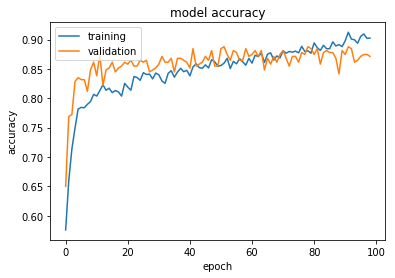

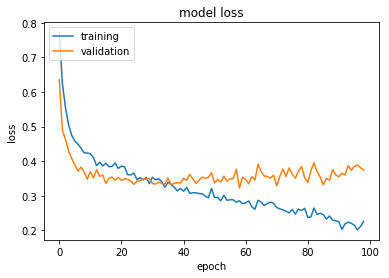

In [29]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
model = init_model()
model.summary()
# X_train = create_seq(X_train)
# y_train = create_seq(y_train.values)
# X_test = create_seq(X_test)
# y_test = create_seq(y_test.values)
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
history = model.fit(X_train, y_train, epochs=200, batch_size=32,validation_data=(X_test,y_test),callbacks=[es])
score = model.evaluate(X_test, y_test, batch_size=32)
print(score)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

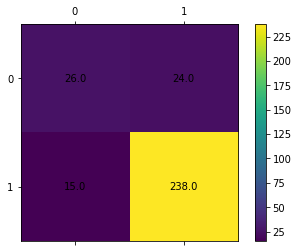

In [30]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


K-fold Cross Validation
----------------------

In [31]:
from sklearn.model_selection import StratifiedKFold

In [32]:
Xs=summer_pca
ys=occ_summer_data.values

289/289 [==============================] - 0s 207us/step


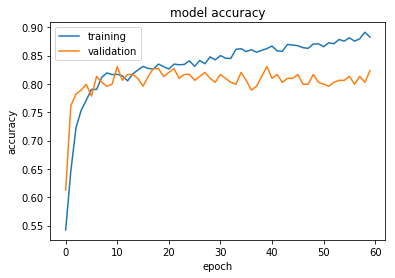

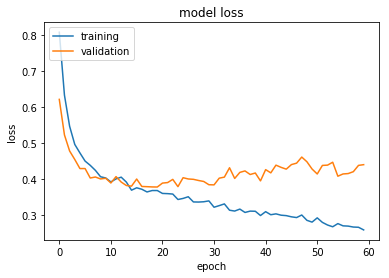

acc: 82.35%
loss: 0.44%
288/288 [==============================] - 0s 218us/step


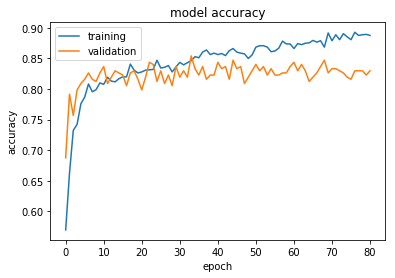

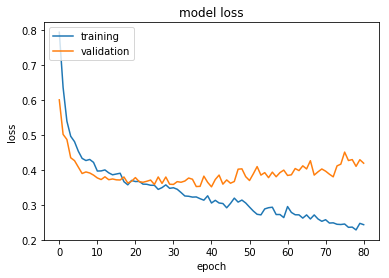

acc: 82.99%
loss: 0.42%
288/288 [==============================] - 0s 177us/step


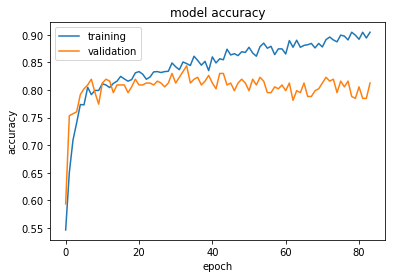

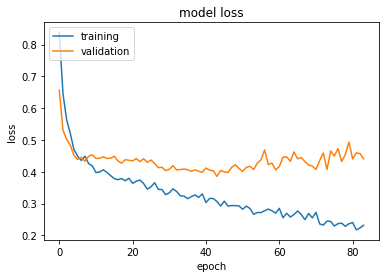

acc: 81.25%
loss: 0.44%
288/288 [==============================] - 0s 243us/step


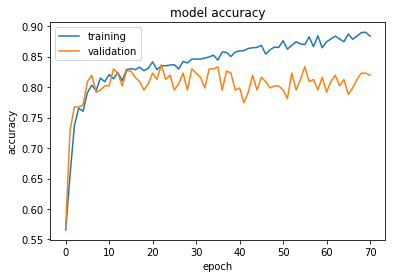

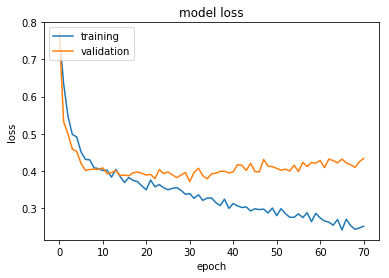

acc: 81.94%
loss: 0.43%
288/288 [==============================] - 0s 252us/step


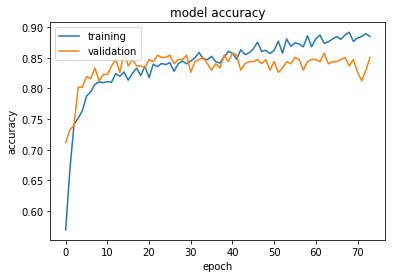

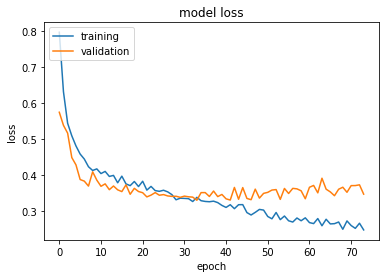

acc: 85.07%
loss: 0.35%
287/287 [==============================] - 0s 190us/step


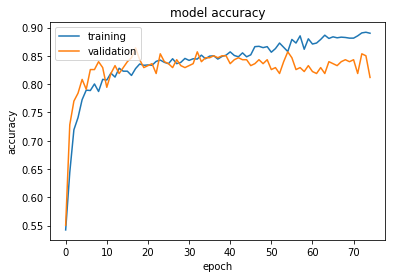

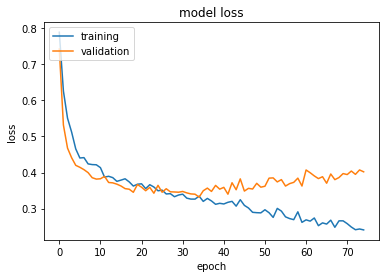

acc: 81.18%
loss: 0.40%
287/287 [==============================] - 0s 288us/step


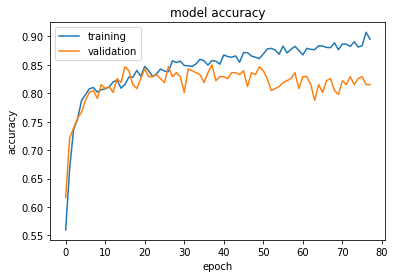

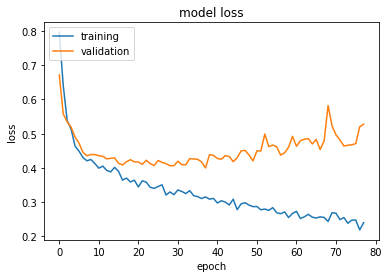

acc: 81.53%
loss: 0.53%
82.33% (+/- 1.26%)


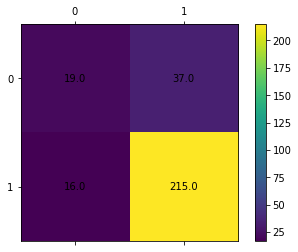

In [33]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    model = init_model()
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

PCA + SVM
=================

In [78]:
from sklearn.svm import SVC
svclassifier = SVC()
svclassifier.fit(X_train, y_train)

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [79]:
y_pred = svclassifier.predict(X_test)

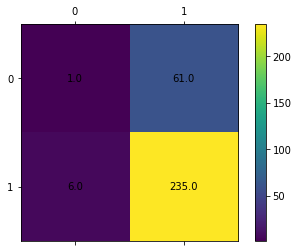

In [80]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


In [81]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.7788778877887789


K-fold
----------

In [82]:
from sklearn.model_selection import StratifiedKFold

In [83]:
Xs=summer_pca
ys=occ_summer_data.values

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 79.93%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.56%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.56%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.56%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.56%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.49%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.49%
80.45% (+/- 0.21%)


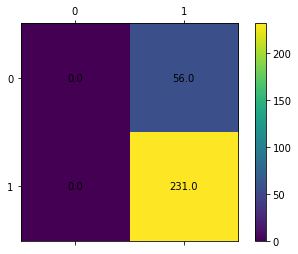

In [84]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train]
    X_test = Xs[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, ys[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    acc = accuracy_score(ys[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Naked NN
================

In [34]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [35]:
# X = np.array(summer_features)
# print('X dim: ',X.shape)
# y = np.array(occ_summer_data)
# print('y dim: ',y.shape)

# X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_std, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_test dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_test dim: ', y_test.shape)

X_train dim:  (1712, 33, 1)
X_test dim:  (303, 33, 1)
y_train dim:  (1712, 1)
y_test dim:  (303, 1)


In [36]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_49 (Batc (None, 33, 256)           1024      
_________________________________________________________________
dropout_49 (Dropout)         (None, 33, 256)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_50 (Batc (None, 33, 128)           512       
_________________________________________________________________
dropout_50 (Dropout)         (None, 33, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 33, 64)            32832     
__________

Train on 1712 samples, validate on 303 samples
Epoch 1/150
 - 7s - loss: 0.7972 - acc: 0.5683 - val_loss: 0.6258 - val_acc: 0.6535
Epoch 2/150
 - 3s - loss: 0.6235 - acc: 0.6665 - val_loss: 0.5117 - val_acc: 0.7129
Epoch 3/150
 - 3s - loss: 0.5470 - acc: 0.7336 - val_loss: 0.5171 - val_acc: 0.7294
Epoch 4/150
 - 3s - loss: 0.4949 - acc: 0.7629 - val_loss: 0.4608 - val_acc: 0.7756
Epoch 5/150
 - 3s - loss: 0.4650 - acc: 0.7956 - val_loss: 0.4567 - val_acc: 0.7888
Epoch 6/150
 - 3s - loss: 0.4622 - acc: 0.7909 - val_loss: 0.4499 - val_acc: 0.7921
Epoch 7/150
 - 3s - loss: 0.4400 - acc: 0.8020 - val_loss: 0.4425 - val_acc: 0.7657
Epoch 8/150
 - 3s - loss: 0.4071 - acc: 0.8242 - val_loss: 0.4479 - val_acc: 0.7525
Epoch 9/150
 - 3s - loss: 0.4090 - acc: 0.8125 - val_loss: 0.4407 - val_acc: 0.7657
Epoch 10/150
 - 3s - loss: 0.3993 - acc: 0.8189 - val_loss: 0.4187 - val_acc: 0.8086
Epoch 11/150
 - 3s - loss: 0.4105 - acc: 0.8137 - val_loss: 0.4136 - val_acc: 0.7921
Epoch 12/150
 - 3s - loss: 

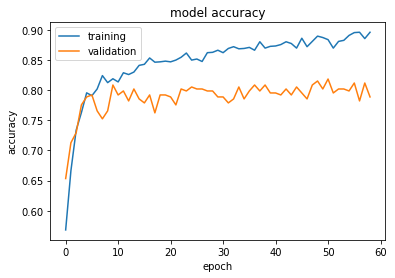

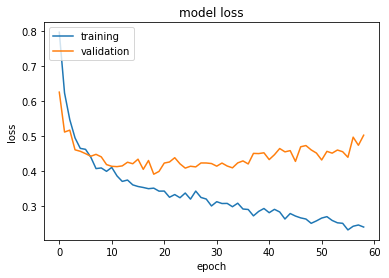

In [37]:
# history = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[es],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

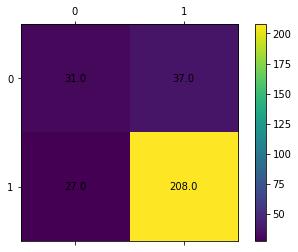

In [38]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test,y_test)

K-fold Validation 
=================

In [39]:
from sklearn.model_selection import StratifiedKFold

In [40]:
Xs=summer_std
ys=occ_summer_data.values

289/289 [==============================] - 0s 443us/step


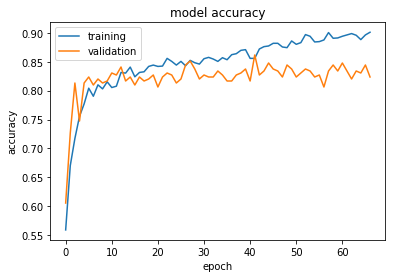

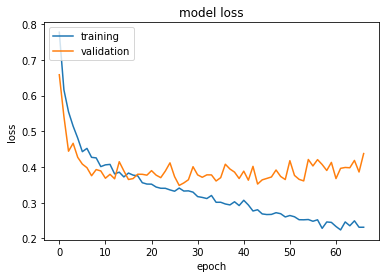

acc: 82.35%
loss: 0.44%
288/288 [==============================] - 0s 455us/step


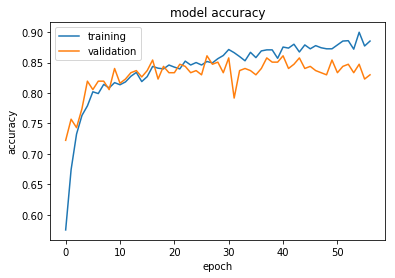

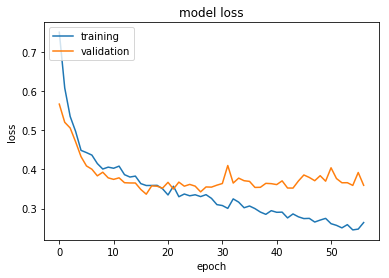

acc: 82.99%
loss: 0.36%
288/288 [==============================] - 0s 502us/step


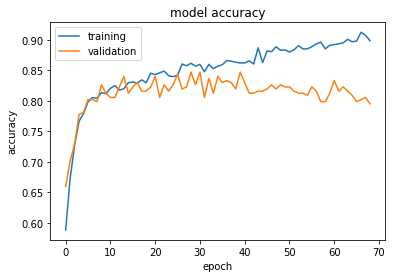

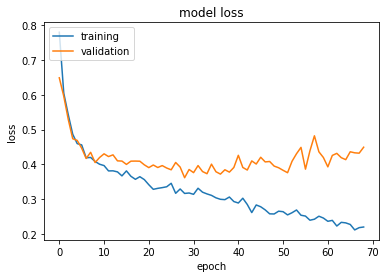

acc: 79.51%
loss: 0.45%
288/288 [==============================] - 0s 539us/step


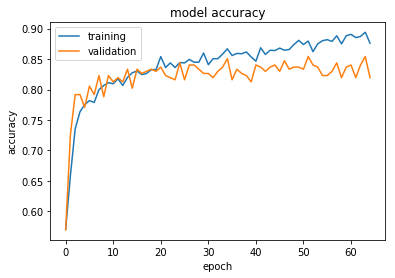

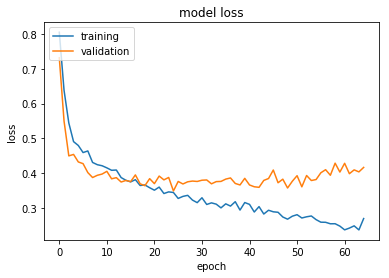

acc: 81.94%
loss: 0.42%
288/288 [==============================] - 0s 605us/step


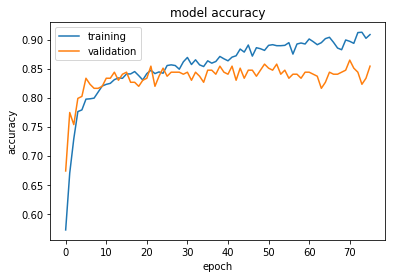

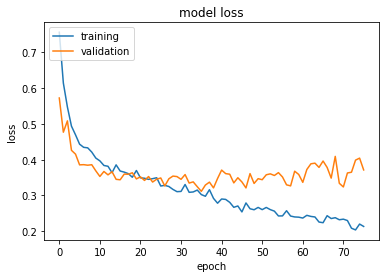

acc: 85.42%
loss: 0.37%
287/287 [==============================] - 0s 650us/step


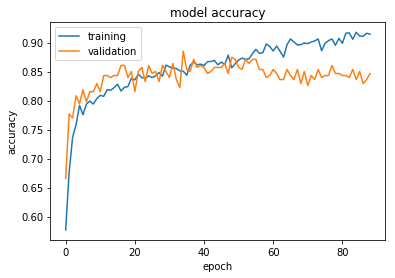

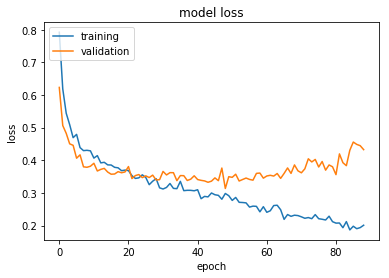

acc: 84.67%
loss: 0.43%
287/287 [==============================] - 0s 644us/step


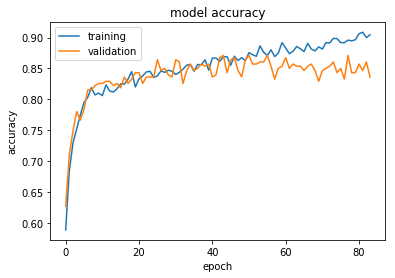

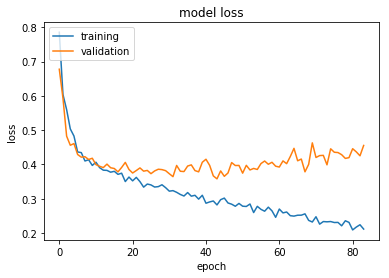

acc: 83.62%
loss: 0.46%
82.93% (+/- 1.80%)


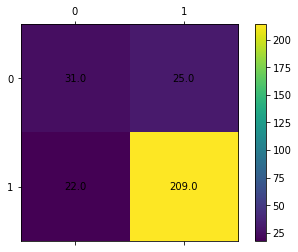

In [41]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    features = X_train.shape[1]
    model = init_model(features)
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Shapely Values
===============

In [42]:
# X = np.array(summer_features)
# print('X dim: ',X.shape)
# y = np.array(occ_summer_data)
# print('y dim: ',y.shape)

# X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(summer_std, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_test dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_test dim: ', y_test.shape)

X_train dim:  (1712, 33, 1)
X_test dim:  (303, 33, 1)
y_train dim:  (1712, 1)
y_test dim:  (303, 1)


In [43]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(1712, 33, 1)

In [44]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

In [45]:
features = X_train.shape[1]
model = init_model(features)
model.summary()
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_97 (Batc (None, 33, 256)           1024      
_________________________________________________________________
dropout_97 (Dropout)         (None, 33, 256)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_98 (Batc (None, 33, 128)           512       
_________________________________________________________________
dropout_98 (Dropout)         (None, 33, 128)           0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 33, 64)            32832     
__________

In [46]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(1712, 33)

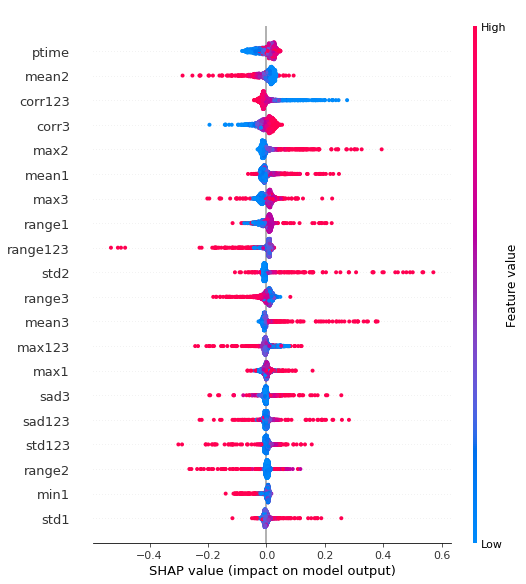

In [47]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

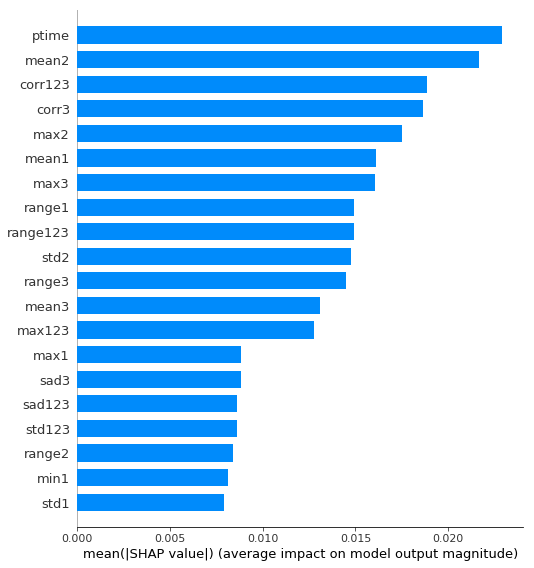

In [48]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

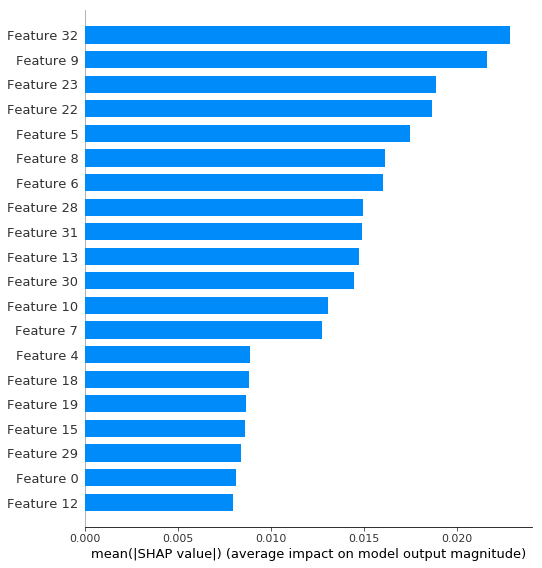

In [49]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely
======================

In [51]:
new_summer_features= summer_std[:,0:1]
new_summer_features = np.concatenate((new_summer_features, summer_std[:,4:11], summer_std[:,12:14],summer_std[:,15:16],
                                     summer_std[:,18:20],summer_std[:,22:24],summer_std[:,28:33]),axis=1)
new_summer_features.shape


(2015, 20)

In [52]:
# X_train1 =new_summer_features[0:2200,:]
# X_test1 = new_summer_features[2200:2535,:]

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_summer_features, occ_summer_data.values, test_size=0.15, shuffle=True)

X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)
X_test1.shape

(303, 20, 1)

In [53]:
model = init_model(X_train1.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_103 (Bat (None, 20, 256)           1024      
_________________________________________________________________
dropout_103 (Dropout)        (None, 20, 256)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_104 (Bat (None, 20, 128)           512       
_________________________________________________________________
dropout_104 (Dropout)        (None, 20, 128)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 20, 64)            32832     
__________

Train on 1712 samples, validate on 303 samples
Epoch 1/200
 - 11s - loss: 0.7529 - acc: 0.5859 - val_loss: 0.5528 - val_acc: 0.7360
Epoch 2/200
 - 3s - loss: 0.6029 - acc: 0.6881 - val_loss: 0.5867 - val_acc: 0.7096
Epoch 3/200
 - 3s - loss: 0.5479 - acc: 0.7255 - val_loss: 0.5107 - val_acc: 0.7492
Epoch 4/200
 - 3s - loss: 0.5172 - acc: 0.7407 - val_loss: 0.5045 - val_acc: 0.7525
Epoch 5/200
 - 3s - loss: 0.4755 - acc: 0.7792 - val_loss: 0.4537 - val_acc: 0.7954
Epoch 6/200
 - 3s - loss: 0.4523 - acc: 0.7891 - val_loss: 0.4393 - val_acc: 0.7789
Epoch 7/200
 - 3s - loss: 0.4493 - acc: 0.7991 - val_loss: 0.4226 - val_acc: 0.7987
Epoch 8/200
 - 3s - loss: 0.4314 - acc: 0.7979 - val_loss: 0.4088 - val_acc: 0.8185
Epoch 9/200
 - 3s - loss: 0.4274 - acc: 0.8026 - val_loss: 0.4058 - val_acc: 0.8152
Epoch 10/200
 - 3s - loss: 0.4176 - acc: 0.8096 - val_loss: 0.3968 - val_acc: 0.8086
Epoch 11/200
 - 3s - loss: 0.4095 - acc: 0.8090 - val_loss: 0.3911 - val_acc: 0.8251
Epoch 12/200
 - 3s - loss:

Epoch 00096: early stopping
303/303 [==============================] - ETA:  - ETA:  - 0s 427us/step
[0.4057856591621248, 0.8547854809084348]


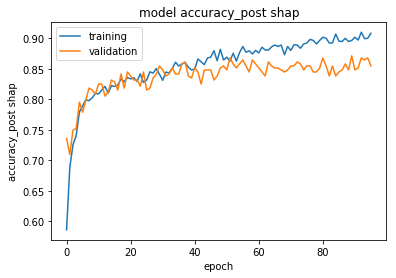

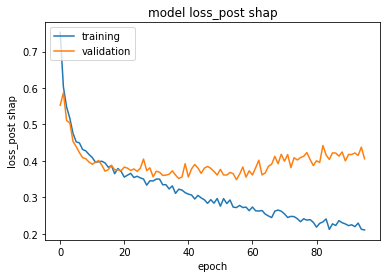

In [55]:
# history1 = LossHistory()
es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss1 = model.fit(X_train1, y_train1, epochs=200, batch_size=32,
                callbacks=[es],
                validation_data=(X_test1,y_test1), verbose=2)
score1 = model.evaluate(X_test1, y_test1, batch_size=64)
print(score1)
plt.plot(hiss1.history['acc'])
plt.plot(hiss1.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss1.history['loss'])
plt.plot(hiss1.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test1)

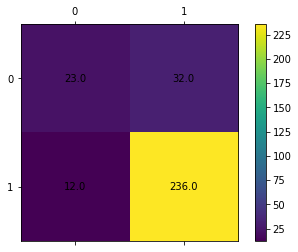

In [56]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

conf_matrix(X_test1,y_test1)

K-fold Validation
---------------------------

In [57]:
from sklearn.model_selection import StratifiedKFold

In [58]:
Xs=new_summer_features
ys=occ_summer_data.values

289/289 [==============================] - ETA:  - ETA:  - ETA:  - 0s 574us/step


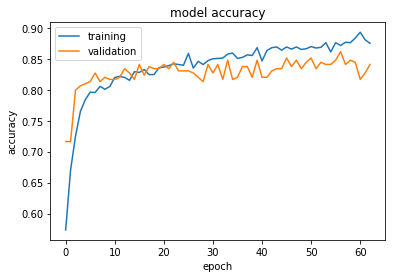

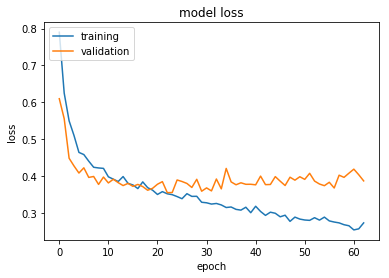

acc: 84.08%
loss: 0.39%
288/288 [==============================] - ETA:  - ETA:  - ETA:  - 0s 688us/step


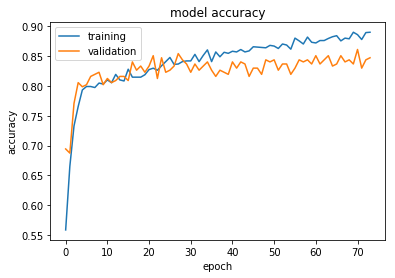

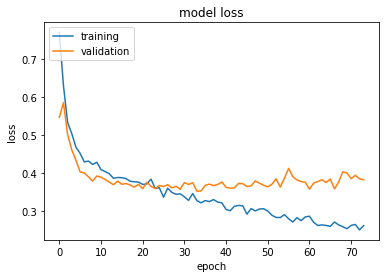

acc: 84.72%
loss: 0.38%
288/288 [==============================] - ETA:  - ETA:  - ETA:  - 0s 679us/step


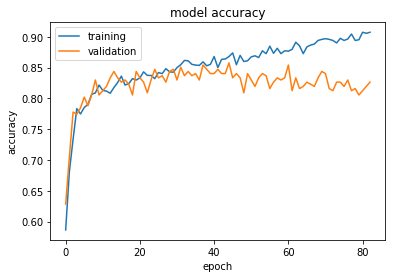

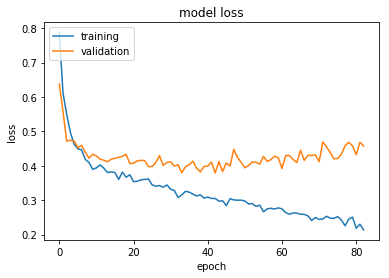

acc: 82.64%
loss: 0.46%
288/288 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 768us/step


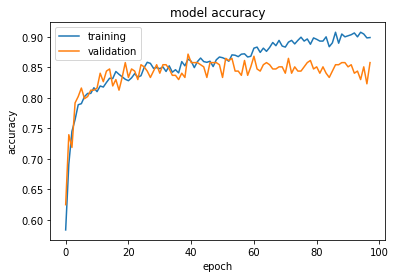

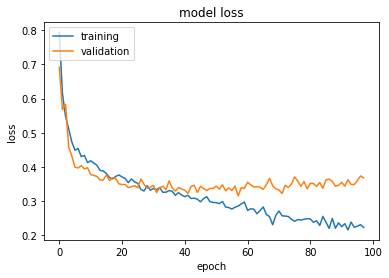

acc: 85.76%
loss: 0.37%
288/288 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 861us/step


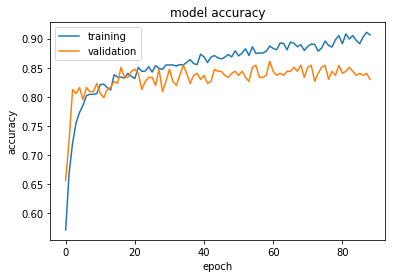

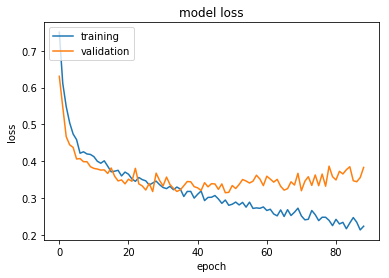

acc: 82.99%
loss: 0.38%
287/287 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 993us/step


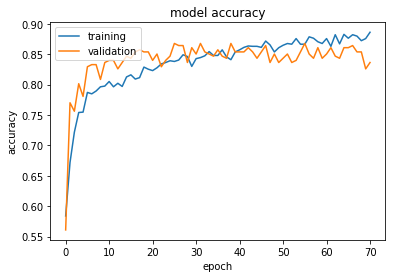

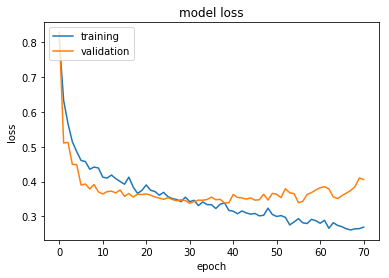

acc: 83.62%
loss: 0.41%
287/287 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 986us/step


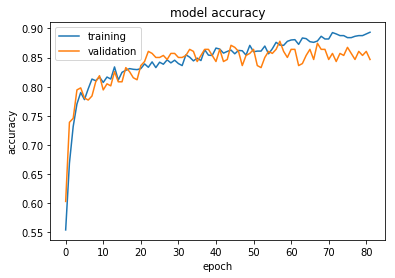

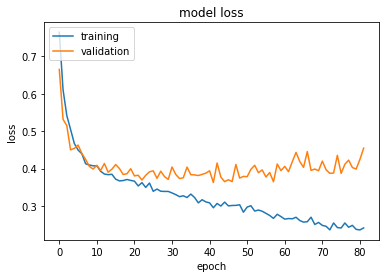

acc: 84.67%
loss: 0.45%
84.07% (+/- 1.01%)


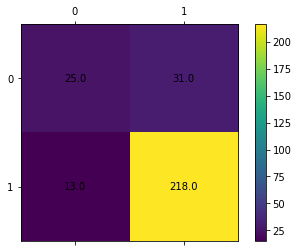

In [59]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvsloss = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train].reshape(Xs[train].shape[0], Xs[train].shape[1],1)
    X_test = Xs[test].reshape(Xs[test].shape[0], Xs[test].shape[1],1)
    features = X_train.shape[1]
    model = init_model(features)
    # X_train = create_seq(X_train)
    # y_train = create_seq(y_train.values)
    # X_test = create_seq(X_test)
    # y_test = create_seq(y_test.values)
    es = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)
    history = model.fit(X_train, ys[train], epochs=200, batch_size=32,validation_data=(X_test,ys[test]),callbacks=[es],verbose=0)
    scores = model.evaluate(X_test, ys[test], batch_size=32)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print("%s: %.2f%%" % (model.metrics_names[0], scores[0]))
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    cvscores.append(scores[1] * 100)
    cvsloss.append(scores[0])
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

Shapely + SVM
===============

In [68]:
# X_train1 =new_summer_features[0:2200,:]
# X_test1 = new_summer_features[2200:2535,:]

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_summer_features, occ_summer_data.values, test_size=0.15, shuffle=True)

# X_train1 = X_train1.reshape(X_train1.shape[0], X_train1.shape[1], 1)
# X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], 1)
X_test1.shape

(303, 20)

In [69]:
from sklearn.svm import SVC
svclassifier = SVC()
svclassifier.fit(X_train1, y_train1)

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [70]:
y_pred = svclassifier.predict(X_test1)

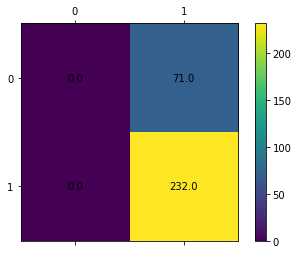

In [71]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
cm = confusion_matrix(y_test, y_pred)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cm)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()


In [72]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test1, y_pred))

0.7854785478547854


K-fold
---------

In [73]:
from sklearn.model_selection import StratifiedKFold

In [74]:
Xs=new_summer_features
ys=occ_summer_data.values

C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.28%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.56%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.56%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.56%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.56%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.49%


C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ghoshp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 80.49%
80.50% (+/- 0.09%)


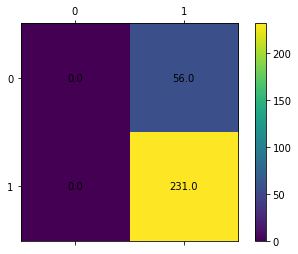

In [75]:
# define 10-fold cross validation test harness
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(Xs, ys):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = Xs[train]
    X_test = Xs[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, ys[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(ys[test], y_pred)
    acc = accuracy_score(ys[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()